# Modelado de distribuciones por radio censal

Este notebook describe un caso de análisis de expansión urbana combinando recursos de los módulos `raster_data_analysis` y `vector_data_analysis`. Con el primero, se genera el límite vectorial del extent de una mancha detectado para cada uno de los períodos censales considerados. Con el segundo, se estima el total de viviendas para un año proyectado y se las localiza en el territorio a partir de las distribuciones observadas en períodos censales previos y/o alguna relación espacial con otra variable relevante.     

El ejemplo que se describe a continuación se basa en la Ciudad de Resistencia y representa un caso de uso en el que, el período proyectado, carece de las geometrías de los radios censales. Esto significa que, para dicho período, también se desconoce el total de viviendas. Por lo tanto,


**A continuación se detalla:**

1. Una estrategia de estimación del total de viviendas/hogares para un año futuro a partir de las proyecciones de personas publicadas por el INDEC.  
2. Una estrategia de distribución espacial de viviendas/hogares por radio censal, a partir de las distribuciones observadas en períodos previos y/o a la relación espacial con otros polígonos de interés.
3. Una estrategia de estimación de indicadores agregados a partir de las distintas categorías de hogares/viviendas disponibles en censos previos (2001 y 2010).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
from CENSAr.datasources import (
    personas_radios_prov,
    tipoviv_radios_prov,
    radios_prov,
    persproy_depto_2025,
)

**Nota aclaratoria sobre el uso de las geometrías y las estrategias de estimación**

Los límites vectoriales que a continuación se cargan para cada uno de los tres períodos censales fueron construídos a partir del módulo `raster data analysis`.

*DESCRIBIR BREVEMENTE CONVOLUSIONES Y CALCULO DE INDICES ACA + HIPERVINCULAR A DOCU*

Cada uno de ellos se utiliza como máscara de recorte para los polígonos de los radios censales disponibles en 2001 y 2010. Dado que las geometrías del 2020 no se encuentran disponibles, los radios censales de 2010 son utilizados dos veces (en 2010 y 2020). Sobre esas mismas geometrías (recortadas en un extent más amplio) también se estimarán los totales de vivienda por radio proyectados para 2020. 


In [4]:
# raster data analysis outputs
import geopandas as gpd
envolvente_resistencia_00 = gpd.read_file('../CENSAr/data/ManchaUrbana_Resistencia_1999.geojson')
envolvente_resistencia_10 = gpd.read_file('../CENSAr/data/ManchaUrbana_Resistencia_2010.geojson')
envolvente_resistencia_20 = gpd.read_file('../CENSAr/data/ManchaUrbana_Resistencia_2022.geojson')


In [5]:
# se cargan las geometrías de las tres fotos censales
chaco_2001 = radios_prov(year=2001, prov="chaco", mask=envolvente_resistencia_00)
chaco_2010 = radios_prov(year=2010, prov="chaco", mask=envolvente_resistencia_10)
# construimos 2020 en base a 2010
chaco_2020 = radios_prov(year=2010, prov="chaco", mask=envolvente_resistencia_20)

In [6]:
# se cargan las tablas de personas para estimar el total de viviendas 2020
tipo_2001 = tipoviv_radios_prov(
    year=2001,
    prov="chaco",
    var_types={"link": "object"},
)
tipo_2001_geo = chaco_2001.set_index("link").join(tipo_2001.set_index("link"))

tipo_2010 = tipoviv_radios_prov(
    year=2010,
    prov="chaco",
    var_types={"link": "object"},
)
tipo_2010_geo = chaco_2010.set_index("link").join(tipo_2010.set_index("link"))

tipo_2020 = tipoviv_radios_prov(
    year=2010,
    prov="chaco",
    var_types={"link": "object"},
)
tipo_2020_geo = chaco_2020.set_index("link").join(tipo_2020.set_index("link"))

[11:25:49] INFO     loading                                                                      ]8;id=238589;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py\datasources.py]8;;\:]8;id=932625;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py#112\112]8;;\
                    `https://storage.googleapis.com/python_mdg/censar_data/tipo_vivienda_radios_                   
                    chaco_2001.csv`                                                                                

           INFO     loading                                                                      ]8;id=922754;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py\datasources.py]8;;\:]8;id=848396;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py#112\112]8;;\
                    `https://storage.googleapis.com/python_mdg/censar_data/tipo_vivienda_radios_                   
                    chaco_2010.csv`                                                                                

           INFO     loading                                                                      ]8;id=199450;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py\datasources.py]8;;\:]8;id=218113;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py#112\112]8;;\
                    `https://storage.googleapis.com/python_mdg/censar_data/tipo_vivienda_radios_                   
                    chaco_2010.csv`                                                                                

## 1.1. Total de Viviendas

Como desconocemos el total de viviendas para 2020, vamos a estimar ese valor a partir de:

1. Proyecciones de población por departamento (INDEC).
2. Ratio `personas por vivienda` observado en los censos `2001` y `2010`.

In [7]:
# Tablas REDATAM - Total personas en 2001 y 2010
pers_2001 = personas_radios_prov(year=2001, prov="chaco", var_types={"link": "object"})
pers_2001_geo = chaco_2001.set_index("link").join(pers_2001.set_index("link"))
pers_2010 = personas_radios_prov(year=2010, prov="chaco", var_types={"link": "object"})
pers_2010_geo = chaco_2010.set_index("link").join(pers_2010.set_index("link"))

[11:25:50] INFO     loading                                                                      ]8;id=273229;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py\datasources.py]8;;\:]8;id=439871;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py#134\134]8;;\
                    `https://storage.googleapis.com/python_mdg/censar_data/personas_radios_chaco                   
                    _2001.csv`                                                                                     

           INFO     loading                                                                      ]8;id=571519;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py\datasources.py]8;;\:]8;id=341374;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py#134\134]8;;\
                    `https://storage.googleapis.com/python_mdg/censar_data/personas_radios_chaco                   
                    _2010.csv`                                                                                     

In [8]:
# Tabla de proyecciones de poblacion por departamento
proy = persproy_depto_2025(prov="chaco")

           INFO     loading,                                                                     ]8;id=885695;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py\datasources.py]8;;\:]8;id=243525;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py#168\168]8;;\
                    `https://storage.googleapis.com/python_mdg/censar_data/persproyect_depto_cha                   
                    co.csv`                                                                                        

## 1.2. Total de viviendas por radio.

Ahora distribuimos el total estimado con la función `totals_forecast` que se ejecuta dentro de `simulate_total_var`. Esta última es quien distribuye este número a lo largo de todos los radios censales (a partir de las distribuciones observadas en `2001` y `2010`). En este ejemplo, se utiliza la distribución observada en `2010` (esto se define en el parámetro `base_year`).



In [9]:
from CENSAr.modeling_tools import (
    simulate_total_var, 
    simulate_cat_var
)

In [10]:
# Total viviendas 2020
tipo_2020_geo["total"] = simulate_total_var(
    gdf_pers_01=pers_2001_geo,
    gdf_var_01=tipo_2001_geo,
    gdf_pers_10=pers_2010_geo,
    gdf_var_10=tipo_2010_geo,
    proy_df=proy,
    namedept="San Fernando",
    base_year="2010",
    forecast_year="2020",
    catname="total",
)

The total number of projected households/residential units is 132527


In [11]:
from CENSAr.plots import (
    compare_chropleths,
    plot_grouped_bars,
    plot_dist_continvar
    )

{'colormap': 'Greys', 'legend': True, 'legend_kwds': {'shrink': 0.3}}


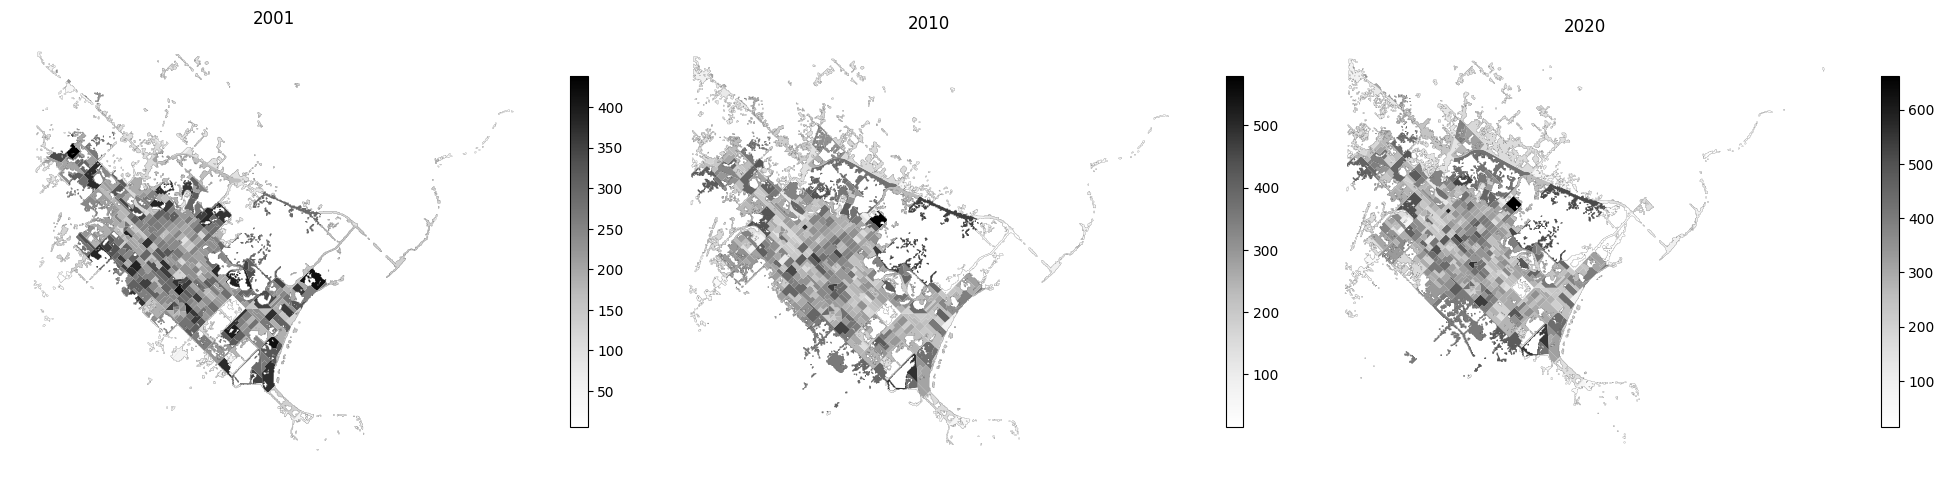

In [12]:
# Se evalúa la distribución generada con simulate_total_var
compare_chropleths(
    tipo_2001_geo,
    tipo_2010_geo,
    tipo_2020_geo,
    column=["total", "total", "total"],
    titles=[2001, 2010, 2020],
    urban_boundaries = [envolvente_resistencia_00, envolvente_resistencia_10, envolvente_resistencia_20],
    figsize=(20,12),
    colormap="Greys"
)

## 2. Total de viviendas por categoria simple

Ahora que contamos con el total de viviendas por radio censal para nuestro año de proyección (`2020`). Dicha columna se utilizará para estimar el total de viviendas correspondiente a alguna tipología específica. En nuestro caso, queremos identificar las `viviendas en condiciones de informalidad-vulnerabilidad urbana`. 

Para ello, utilizamos la función `simulate_cat_var`. Esta permite distribuir frecuencias de una variable a lo largo de un conjunto de radios censales siguiendo una serie de reglas. Entre ellas, es necesario definir a qué período censal corresponden las distribuciones observadas que se van a utilizar para realizar la asignación de frecuencias por radio en el año de proyección. Los parámetros `gdf_var_01` y `gdf_var_10` sirven para obtener esta información. Por su parte, `forecast_gdf` es donde se simulará la asignación de frecuencias.  

Nuevamente, como no disponemos de las geometrías en `2020` el parámetro `forecast_gdf` se encuentra recibiendo las geometrías de `2010` pero en un extent más amplío (es decir, lo tratamos como un geodataframe diferente a pesar de ser los mismos radios).
Esta función recibe tres geodataframes. Dos para observar distribuciones por radio censal (`2001` y `2010`) y uno para modelar la distribución por radio en el año de proyección (`2020`).

La cantidad de viviendas de la categoría en cuestión se define a partir de un porcentaje teórico u observado. Este refleja el peso que tiene dicha categoría en el total de viviendas (e.g. `2.5%`). El parametro `pct_val` permite definir el total de frecuencias de una categoría específica a partir del total de frecuencias del universo en su conjunto. Esto permite analizar tanto escenarios de crecimiento como de decrecimiento (para esto último bastaría con definir un porcentaje inferior al observado en un período previo)

Además, la función `simulate_cat_var` cuenta con el parámetro `calibration_vector` que permite incorporar una nueva distribución observada por radio censal (utilizada para captar alguna relación espacial con otro polígono de interés). Más adelante, se ejemplifica su uso.

In [13]:
# Con catname uso la distribucion de una variable en 2001 y de otra en 2010 en funcion del diccionario que pasamos como parametro
simulated_distribution = simulate_cat_var(
    gdf_var_01=tipo_2001_geo,
    gdf_var_10=tipo_2020_geo,
    base_year="2010",
    forecast_year="2020",
    forecast_gdf=tipo_2020_geo,
    pct_val=1.5,
    catname={"2001": "casilla", "2010": "casilla"},
    tot_colname="total",
    calibration_vector={'weights':None, 'mix_dist':False}
    )

# Tratamos al gdf tipo_2020_geo como uno distinto al del 2010
tipo_2020_geo["cat_sim"] = tipo_2020_geo.index.map(simulated_distribution)
tipo_2020_geo["casilla_2020"] = tipo_2020_geo["casilla"] + tipo_2020_geo["cat_sim"] 

{'colormap': 'YlOrRd', 'legend': True, 'legend_kwds': {'shrink': 0.3}}


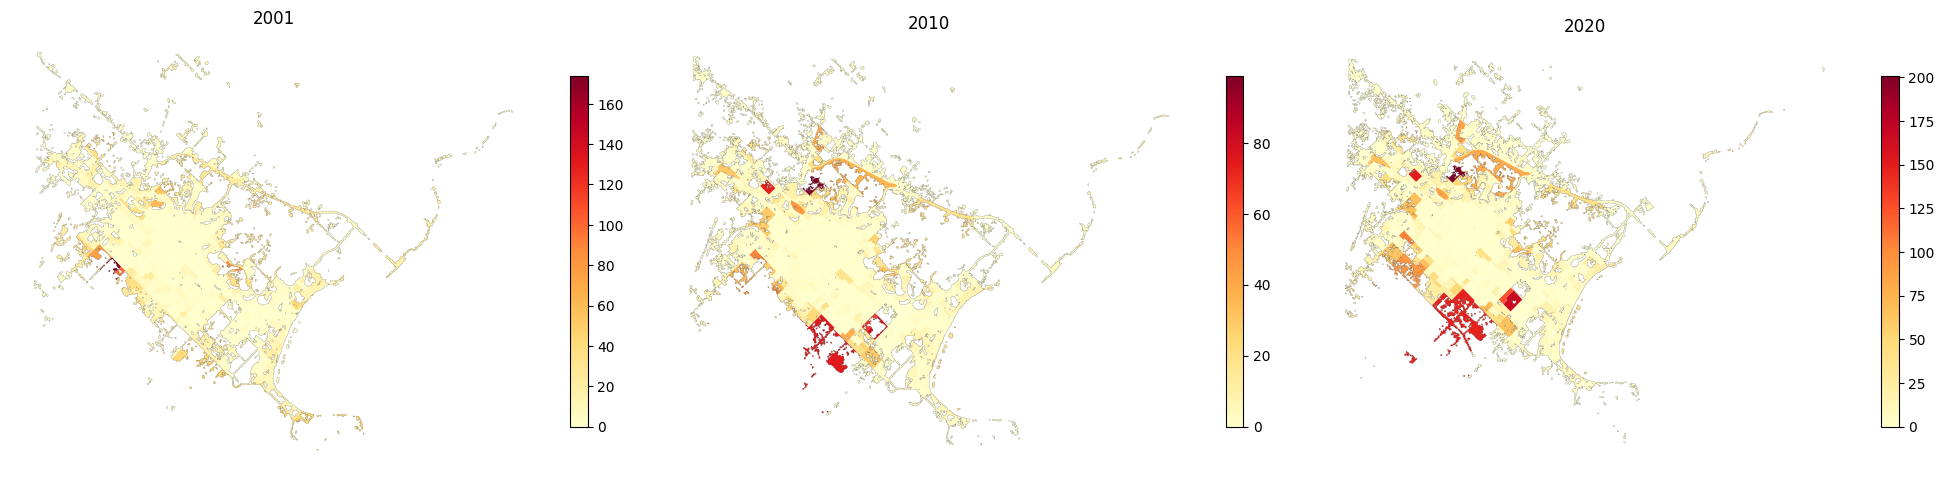

In [14]:
compare_chropleths(
    tipo_2001_geo,
    tipo_2010_geo,
    tipo_2020_geo,
    column=["casilla", "casilla", "casilla_2020"],
    titles=[2001, 2010, 2020],
    urban_boundaries = [envolvente_resistencia_00, envolvente_resistencia_10, envolvente_resistencia_20],
    figsize=(20,12),
    colormap = 'YlOrRd'
)

### 2.1. Vectores de calibración

El parámetro `calibration_vector` de la función `simulate_cat_var` permite incluir una nueva distribución observada. En este ejemplo, utilizamos el porcentaje del área de un radio censal cubierta por el polígono de un asentamiento informal.

El diccionario que se utiliza debe especificar dos llaves. Una indicando el objeto que se va a mapear como vector de nuevos pesos ('weights') y otra indicando si esta distribución observada se va a utilizar junto a las de 2001-2010 o no. En este último caso, se debe especificar `mix_dist:False`. Esto significa que las distribuciones definidas con el parámetro `base_year` se sobreescriben. De esta manera la asignación de frecuencias por radio para el año de proyección sólo sigue el vector de pesos definido en la llave `weights` del parametro `calibration_vector`.

In [15]:
import pandas as pd
from CENSAr.vector_data_analysis.geoprocessing import (from_wkt, build_thiner_pct_in_coarser_geom)

In [16]:
# Superficie cubierta por asentamientos informales
url = "https://storage.googleapis.com/python_mdg/censar_data/informal_settlements_072022.csv"
asentamientos = pd.read_csv(url)
asentamientos_gdf = from_wkt(df=asentamientos, wkt_column='geometry')

tipo_2020_reset = tipo_2020_geo.reset_index()
calibration_weights = build_thiner_pct_in_coarser_geom(coarser_geom=tipo_2020_reset, thiner_geom=asentamientos_gdf,
                                                       coarser_idx='link', thiner_idx='id_renabap', crs=5347)

In [17]:
simulated_distribution = simulate_cat_var(
    gdf_var_01=tipo_2001_geo,
    gdf_var_10=tipo_2020_geo,
    base_year="0110",
    forecast_year="2020",
    forecast_gdf=tipo_2020_geo,
    pct_val=1.2,
    catname={"2001": "casilla", "2010": "casilla"},
    tot_colname="total",
    calibration_vector={'weights':calibration_weights, 'mix_dist':True}
    )

tipo_2020_geo["cat_sim"] = tipo_2020_geo.index.map(simulated_distribution)
tipo_2020_geo["casilla_2020"] = tipo_2020_geo["casilla"] + tipo_2020_geo["cat_sim"] 

{'colormap': 'YlOrRd', 'legend': True, 'legend_kwds': {'shrink': 0.3}}


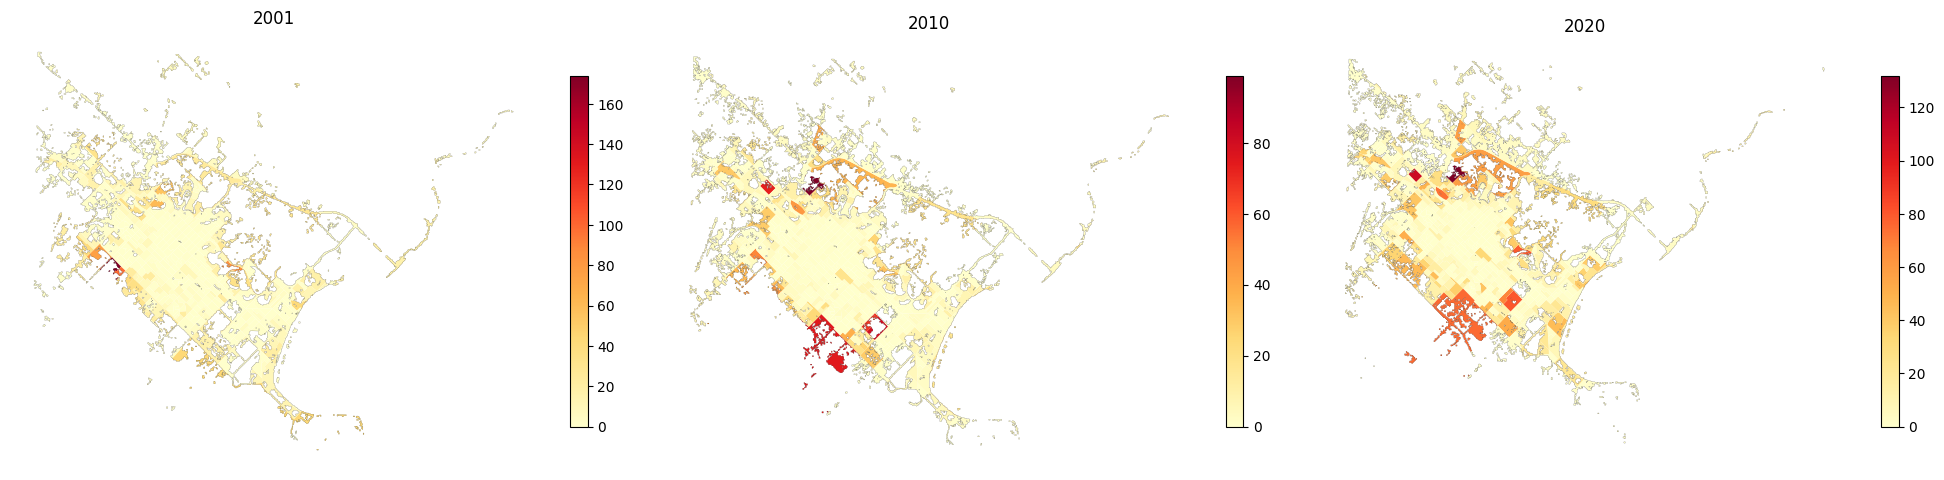

In [18]:
compare_chropleths(
    tipo_2001_geo,
    tipo_2010_geo,
    tipo_2020_geo,
    column=["casilla", "casilla", "casilla_2020"],
    titles=[2001, 2010, 2020],
    urban_boundaries = [envolvente_resistencia_00, envolvente_resistencia_10, envolvente_resistencia_20],
    figsize=(20,12),
    colormap = 'YlOrRd'
)

# 3. Agregacion de indicadores

El módulo `aggregation` permite construir indicadores a partir de la agregación de categorías simples de una variable. Esto, tanto para el universo de hogares como de viviendas. Dicha agregación se configura a partir de los archivos `.yaml` que se encuentran en el mismo directorio.

In [19]:
# Vemos las categorías disponibles
tipo_2001_geo.columns

Index(['geometry', 'casa a', 'casa b', 'rancho', 'casilla', 'departamento',
       'pieza en inquilinato', 'pieza en hotel o pension',
       'local no construido para habitacion', 'vivienda movil', 'en la calle',
       'total'],
      dtype='object')

In [20]:
tipo_2010_geo.columns

Index(['geometry', 'casa', 'rancho', 'casilla', 'departamento',
       'pieza en inquilinato', 'pieza en hotel o pension',
       'local no construido para habitacion', 'vivienda movil', 'en la calle',
       'total'],
      dtype='object')

In [21]:
tipo_2020_geo.columns

Index(['geometry', 'casa', 'rancho', 'casilla', 'departamento',
       'pieza en inquilinato', 'pieza en hotel o pension',
       'local no construido para habitacion', 'vivienda movil', 'en la calle',
       'total', 'cat_sim', 'casilla_2020'],
      dtype='object')

### 3.1. Informalidad por tipo de vivienda

A continuación se detalla un ejemplo con la variable `tipo de vivienda`. Aquellas categorías que responden a condiciones de informalidad o vulnerabilidad urbanas se agruparan bajo una misma etiqueta. En nuestro caso, [el CNPHV2010 define](https://redatam.indec.gob.ar/redarg/CENSOS/CPV2010rad/Docs/base.pdf) como:

1. `Rancho`: vivienda con salida directa al exterior (sus habitantes no pasan por pasillos o corredores de uso común) construida originalmente para que habiten personas. Generalmente tiene paredes de adobe, piso de tierra y techo de chapa o paja. Se considera propia de áreas rurales.

2. `Casilla`: vivienda con salida directa al exterior, construida originalmente para que habiten personas (sus habitantes no pasan por pasillos o corredores de uso común). Habitualmente está construida con materiales de baja calidad o de desecho y se considera propia de áreas urbanas.  

3. `Local no construido para habitación`: vivienda que no ha sido construida o adaptada para quehabiten personas pero en la que hubo personas que pasaron la noche de referencia del Censo.

In [22]:
from CENSAr.aggregation import named_aggregation

tipo_vivienda_agg_2001 = named_aggregation(
    tipo_2001_geo, name="tipo vivienda particular"
)
tipo_vivienda_agg_2010 = named_aggregation(
    tipo_2010_geo, name="tipo vivienda particular"
)
tipo_vivienda_agg_2020 = named_aggregation(
    tipo_2020_geo, name="tipo vivienda particular"
)

[11:26:26] INFO     Applying named aggregation `tipo vivienda particular`                                ]8;id=307856;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=633925;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py#67\67]8;;\

           WARNING  Extra columns found for mapping situacion de calle: {'persona viviendo en la        ]8;id=596812;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=421284;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py#123\123]8;;\
                    calle'}. Extra columns will be ignored.                                                        

           INFO     Applying named aggregation `tipo vivienda particular`                                ]8;id=209259;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=665220;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py#67\67]8;;\

           WARNING  Extra columns found for mapping formal: {'casa a', 'casa b'}. Extra columns will be ]8;id=881173;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=453024;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py#123\123]8;;\
                    ignored.                                                                                       

           WARNING  Extra columns found for mapping situacion de calle: {'persona viviendo en la        ]8;id=102415;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=6462;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py#123\123]8;;\
                    calle'}. Extra columns will be ignored.                                                        

           INFO     Applying named aggregation `tipo vivienda particular`                                ]8;id=385270;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=486468;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py#67\67]8;;\

           WARNING  Extra columns found for mapping formal: {'casa a', 'casa b'}. Extra columns will be ]8;id=469822;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=383621;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py#123\123]8;;\
                    ignored.                                                                                       

           WARNING  Extra columns found for mapping situacion de calle: {'persona viviendo en la        ]8;id=216526;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=616813;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py#123\123]8;;\
                    calle'}. Extra columns will be ignored.                                                        

In [23]:
# distribuciones formal e informal
formal_simulated_distribution = simulate_cat_var(
    gdf_var_01=tipo_vivienda_agg_2001,
    gdf_var_10=tipo_vivienda_agg_2020,
    base_year="0110",
    forecast_year="2020",
    forecast_gdf=tipo_vivienda_agg_2020,
    pct_val=97,
    catname={"2001": "formal", "2010": "formal"},
    tot_colname="total",
)
informal_simulated_distribution = simulate_cat_var(
    gdf_var_01=tipo_vivienda_agg_2001,
    gdf_var_10=tipo_vivienda_agg_2020,
    base_year="0110",
    forecast_year="2020",
    forecast_gdf=tipo_vivienda_agg_2020, 
    pct_val=2.5,
    catname={"2001": "informal", "2010": "informal"},
    tot_colname="total",
)
calle_simulated_distribution = simulate_cat_var(
    gdf_var_01=tipo_vivienda_agg_2001,
    gdf_var_10=tipo_vivienda_agg_2020,
    base_year="0110",
    forecast_year="2020",
    forecast_gdf=tipo_vivienda_agg_2020,
    pct_val=0.5,
    catname={"2001": "situacion de calle", "2010": "situacion de calle"},
    tot_colname="total",
)

# Sumo los nuevos casos simulados sobre la distribucion del período previo al proyectado 
# (suponemos un escenario de estatus quo o crecimiento lineal. Es decir, los radios no pierden viviendas, sólo reciben)
tipo_vivienda_agg_2020["cat_sim"] = tipo_vivienda_agg_2020.index.map(formal_simulated_distribution)
tipo_vivienda_agg_2020["formal"] = tipo_vivienda_agg_2020["formal"] + tipo_2020_geo["cat_sim"] 

tipo_vivienda_agg_2020["cat_sim"] = tipo_vivienda_agg_2020.index.map(informal_simulated_distribution)
tipo_vivienda_agg_2020["informal"] = tipo_vivienda_agg_2020["informal"] + tipo_2020_geo["cat_sim"]

tipo_vivienda_agg_2020["cat_sim"] = tipo_vivienda_agg_2020.index.map(calle_simulated_distribution)
tipo_vivienda_agg_2020["situacion de calle"] = tipo_vivienda_agg_2020["situacion de calle"] + tipo_2020_geo["cat_sim"]

{'colormap': 'YlOrRd', 'legend': True, 'legend_kwds': {'shrink': 0.3}}


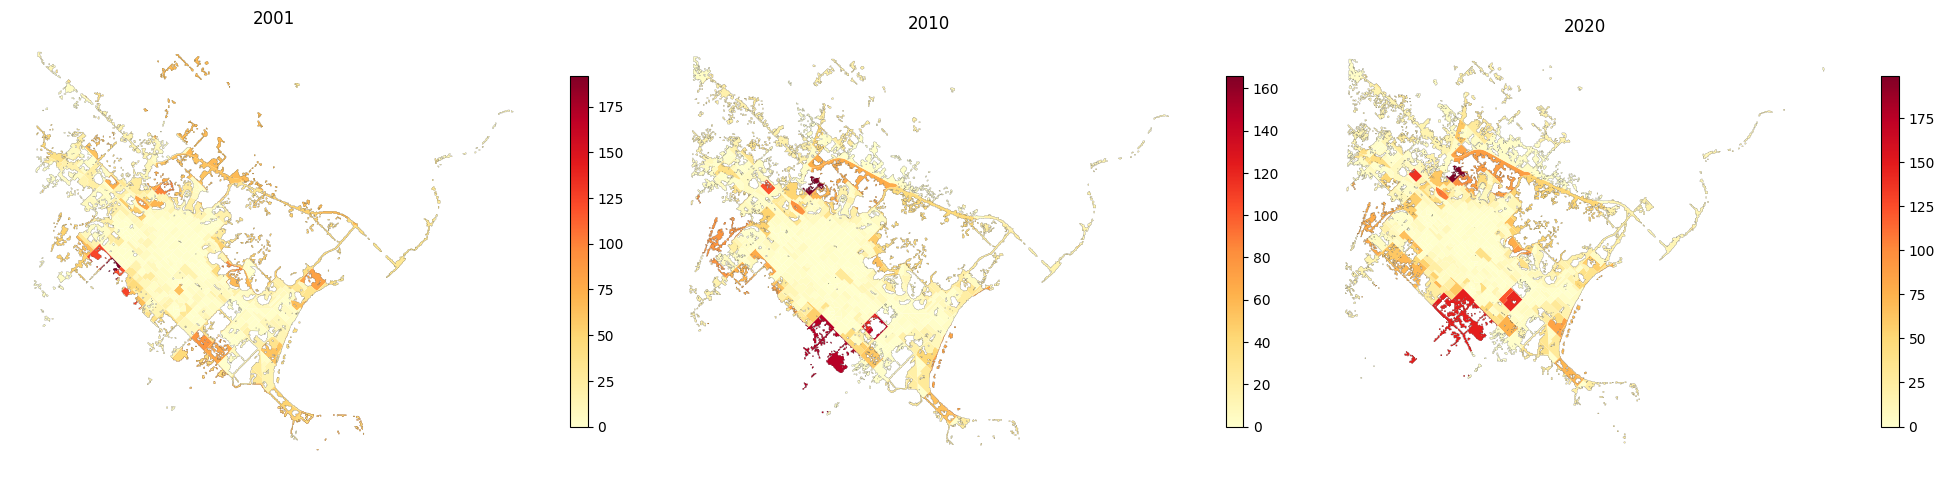

In [24]:
# INFORMAL
compare_chropleths(
    tipo_vivienda_agg_2001,
    tipo_vivienda_agg_2010,
    tipo_vivienda_agg_2020,
    column=["informal","informal","informal"],
    titles=[2001, 2010, 2020],
    urban_boundaries = [envolvente_resistencia_00, envolvente_resistencia_10, envolvente_resistencia_20],
    figsize=(20,12),
    colormap = 'YlOrRd'
)

{'colormap': 'YlOrRd', 'legend': True, 'legend_kwds': {'shrink': 0.3}}


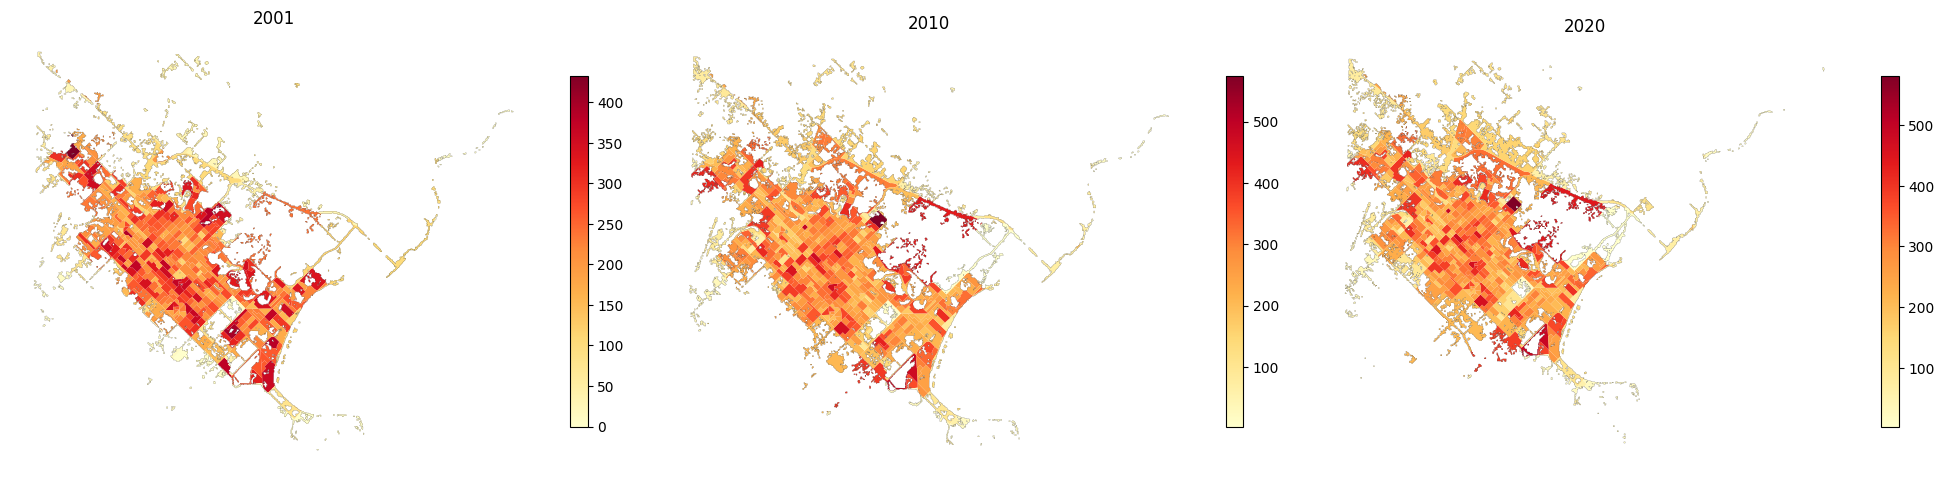

In [25]:
# FORMAL
compare_chropleths(
    tipo_vivienda_agg_2001,
    tipo_vivienda_agg_2010,
    tipo_vivienda_agg_2020,
    column=["formal","formal","formal"],
    titles=[2001, 2010, 2020],
    urban_boundaries = [envolvente_resistencia_00, envolvente_resistencia_10, envolvente_resistencia_20],
    figsize=(20,12),
    colormap = 'YlOrRd'
)

### 3.2. Viviendas informales - totales de referencia

Para determinar cuál es el porcentaje que representa una categoría específica tomamos en cuenta el total de viviendas de las geomtrías que utilizamos como vector de calibración. A continuación revisamos totales de referencia para la categoría `viviendas informales`.

In [26]:
# Polígonos de asentamientos informales en los límites del Gran Resistencia
inf_chaco = asentamientos_gdf.loc[(asentamientos_gdf['provincia'].isin(['Chaco'])) & 
                                  (asentamientos_gdf['departamento'].isin(['San Fernando']))].copy()

inf_chaco['decada_label'] = inf_chaco.decada_de_creacion.apply(lambda x: x[7:11])

# Tabla con totales de referencia
df = pd.DataFrame(inf_chaco.groupby('decada_label')['cantidad_viviendas_aproximadas'].sum().astype(int))
df_ = df.loc[df.index.isin(['2000','2010']),['cantidad_viviendas_aproximadas']].copy()
df_['viviendas totales (CNPHV)'] = [tipo_vivienda_agg_2001['total'].sum(), tipo_vivienda_agg_2010['total'].sum()]
df_['viviendas informales (tipo - CNPHV)'] = [tipo_vivienda_agg_2001['informal'].sum(), tipo_vivienda_agg_2010['informal'].sum()]
df_.rename(columns={'cantidad_viviendas_aproximadas': 'viviendas informales (Renabap)'}, inplace=True)
df_ = df_[['viviendas informales (Renabap)', 'viviendas informales (tipo - CNPHV)', 'viviendas totales (CNPHV)']].copy()

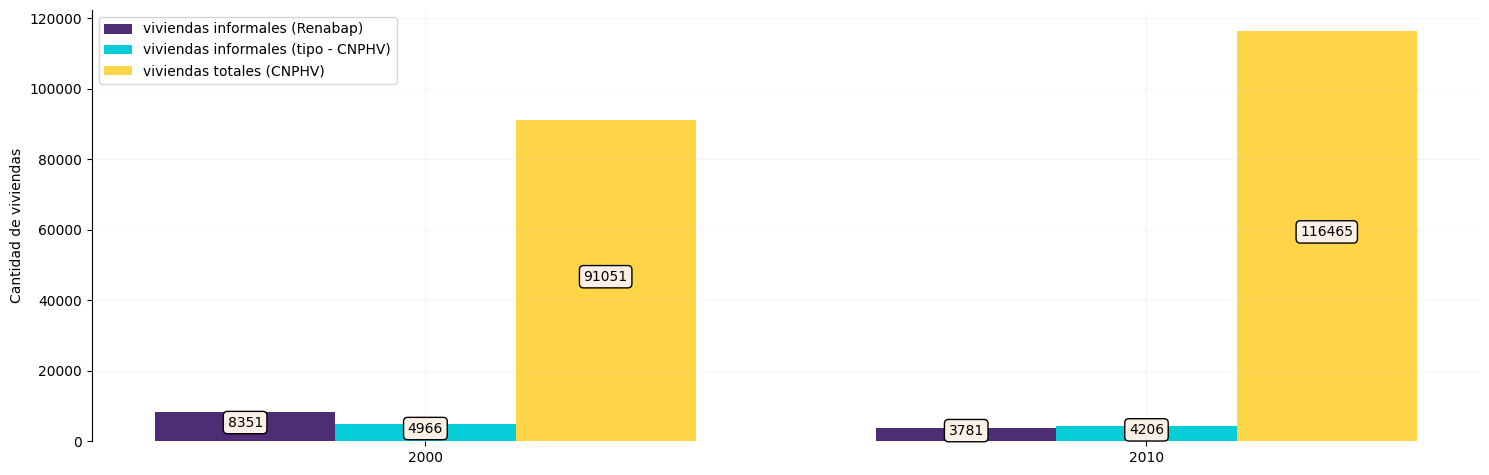

In [27]:
yaxis_formatter=None
xaxis_formatter=None
xticks_rotation = 0

fcolor = 'linen'
tcolor = 'black'

colors = {'viviendas informales (Renabap)':'#4e2c76', 
          'viviendas informales (tipo - CNPHV)':'#07cdd8', 
          'viviendas totales (CNPHV)':'#fed547'}
len_groups = 2
bar_width = 0.25

yaxis_name = 'Cantidad de viviendas'
ylim = None
chart_title = None
figsize=(15,5)

plot_grouped_bars(df_.T, figsize, chart_title, len_groups, bar_width, colors, fcolor, tcolor, yaxis_name, yaxis_formatter, ylim, xaxis_formatter, xticks_rotation)    

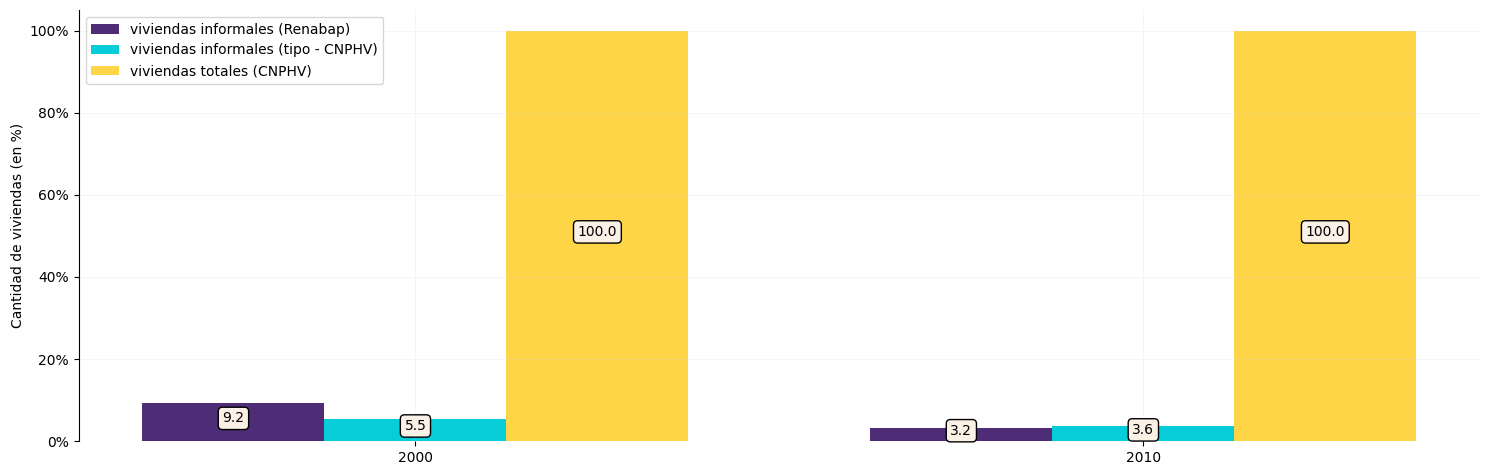

In [28]:
# Tabla con porcentajes de referencia
df_pct = df_.copy()
df_pct['viviendas informales (Renabap)'] = round(df_pct['viviendas informales (Renabap)']/df_pct['viviendas totales (CNPHV)']*100,1)
df_pct['viviendas informales (tipo - CNPHV)'] = round(df_pct['viviendas informales (tipo - CNPHV)']/df_pct['viviendas totales (CNPHV)']*100,1)
df_pct['viviendas totales (CNPHV)'] = round(df_pct['viviendas totales (CNPHV)']/df_pct['viviendas totales (CNPHV)']*100,1)

yaxis_formatter='{}%'

yaxis_name = 'Cantidad de viviendas (en %)'
figsize=(15,5)

plot_grouped_bars(df_pct.T, figsize, chart_title, len_groups, bar_width, colors, fcolor, tcolor, yaxis_name, yaxis_formatter, ylim, xaxis_formatter, xticks_rotation)

In [29]:
tipo_vivienda_agg_2020 = named_aggregation(
    tipo_2020_geo, name="tipo vivienda particular"
)

# calibrando por el area total de asentamientos informales
calibration_weights = build_thiner_pct_in_coarser_geom(coarser_geom=tipo_2020_reset, thiner_geom=asentamientos_gdf,
                                                       coarser_idx='link', thiner_idx='id_renabap', crs=5347, coarser_tot=False)

informal_simulated_distribution = simulate_cat_var(
    gdf_var_01=tipo_vivienda_agg_2001,
    gdf_var_10=tipo_vivienda_agg_2020,
    base_year="0110",
    forecast_year="2020",
    forecast_gdf=tipo_vivienda_agg_2020,
    pct_val=3.5,
    catname={"2001": "informal", "2010": "informal"},
    tot_colname="total",
    calibration_vector={'weights':calibration_weights, 'mix_dist':True}
)

tipo_vivienda_agg_2020["cat_sim"] = tipo_vivienda_agg_2020.index.map(informal_simulated_distribution)
tipo_vivienda_agg_2020["informal_2020"] = tipo_vivienda_agg_2020["informal"] + tipo_vivienda_agg_2020["cat_sim"] 

[11:26:47] INFO     Applying named aggregation `tipo vivienda particular`                                ]8;id=972227;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=665654;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py#67\67]8;;\

           WARNING  Extra columns found for mapping formal: {'casa a', 'casa b'}. Extra columns will be ]8;id=412291;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=760006;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py#123\123]8;;\
                    ignored.                                                                                       

           WARNING  Extra columns found for mapping situacion de calle: {'persona viviendo en la        ]8;id=188642;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=805533;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py#123\123]8;;\
                    calle'}. Extra columns will be ignored.                                                        

{'scheme': 'NaturalBreaks', 'k': 4, 'colormap': 'YlOrRd', 'legend': True, 'legend_kwds': {'fmt': '{:.0f}'}}


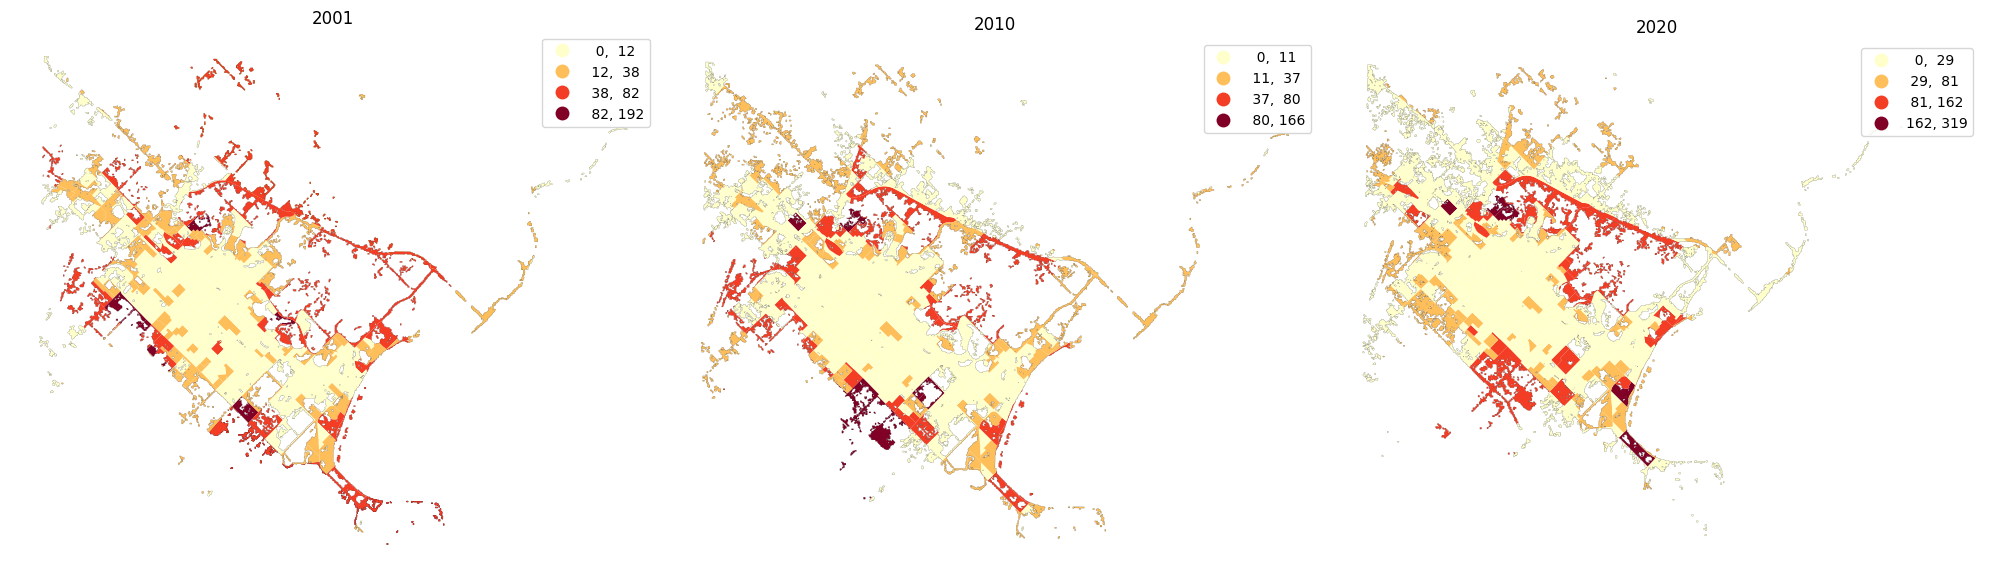

In [30]:
compare_chropleths(
    tipo_vivienda_agg_2001,
    tipo_vivienda_agg_2010,
    tipo_vivienda_agg_2020,
    column=["informal","informal","informal_2020"],
    titles=[2001, 2010, 2020],
    urban_boundaries = [envolvente_resistencia_00, envolvente_resistencia_10, envolvente_resistencia_20],
    figsize=(20,12),
    legend_kwds = {'fmt':'{:.0f}'},
    scheme = "NaturalBreaks",
    k = 4,
    colormap = 'YlOrRd'
)

{'colormap': 'YlOrRd', 'legend': True, 'legend_kwds': {'shrink': 0.3}}


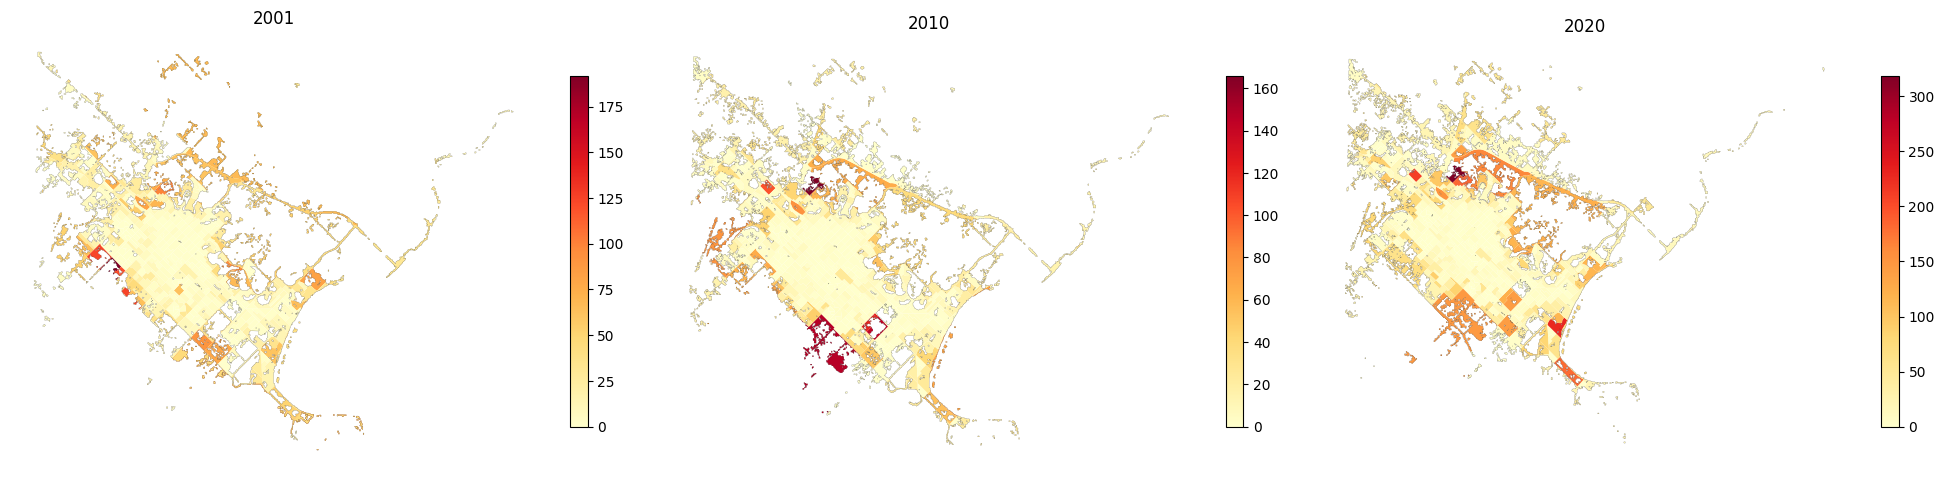

In [31]:
compare_chropleths(
    tipo_vivienda_agg_2001,
    tipo_vivienda_agg_2010,
    tipo_vivienda_agg_2020,
    column=["informal","informal","informal_2020"],
    titles=[2001, 2010, 2020],
    urban_boundaries = [envolvente_resistencia_00, envolvente_resistencia_10, envolvente_resistencia_20],
    figsize=(20,12),
    colormap = 'YlOrRd'
)

### 3.3. Distribución de viviendas por radio censal

Ahora vamos a revisar las distribuciones de vivienda por radio censal que utilizamos como vector de pesos. Asimismo, veremos cuánto se asemeja nuestra distribución proyectada siguiendo los criterios definidos en nuestra última ejecución de la función `simulate_cat_var`.

Esto es, 

*Parametros del escenario*

* Las viviendas informales en `2020` representan el 3.5% de las viviendas totales (similar período `2010`)
* Se utiliza una distribución intermedia entre las observadas en `2001` y `2010` como vector de pesos.
* Se utiliza la proporción que cada radio posee del total de superficie informal (según renabap) como vector de pesos.

#### 3.3.1 Viviendas informales por radio censal 2001

In [32]:
tipo_vivienda_agg_2001['informal'].describe()

count    384.000000
mean      12.932292
std       22.796766
min        0.000000
25%        1.000000
50%        4.000000
75%       15.000000
max      192.000000
Name: informal, dtype: float64

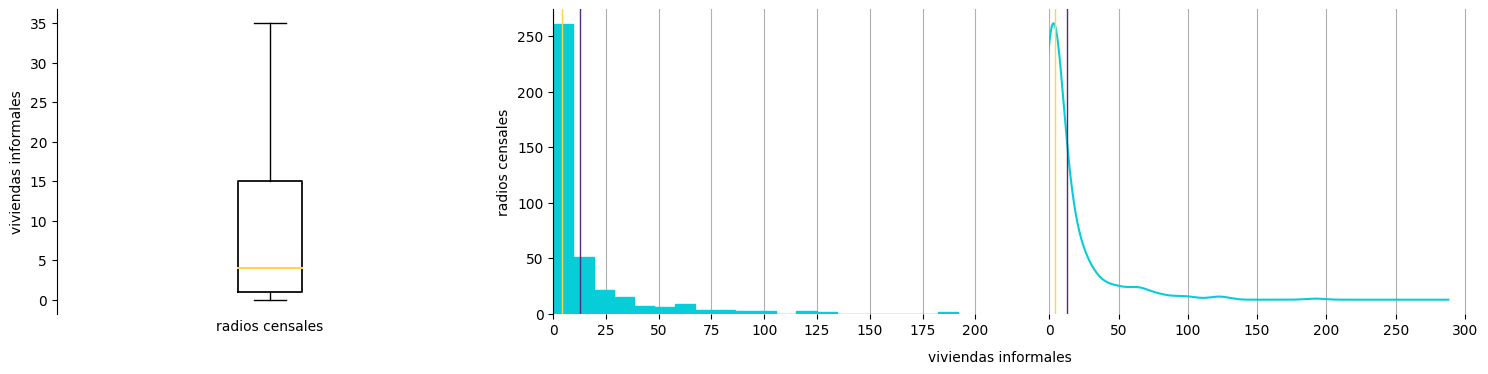

In [33]:
plot_dist_continvar(serie=tipo_vivienda_agg_2001['informal'], figsize=(15,4), fill_hist=True, 
                    xlabel='radios censales', ylabel='viviendas informales', tit=None, bval=20, lim=None)

#### 3.3.2 Viviendas informales por radio censal 2010

In [34]:
tipo_vivienda_agg_2010['informal'].describe()

count    443.000000
mean       9.494357
std       19.824726
min        0.000000
25%        0.000000
50%        2.000000
75%        8.000000
max      166.000000
Name: informal, dtype: float64

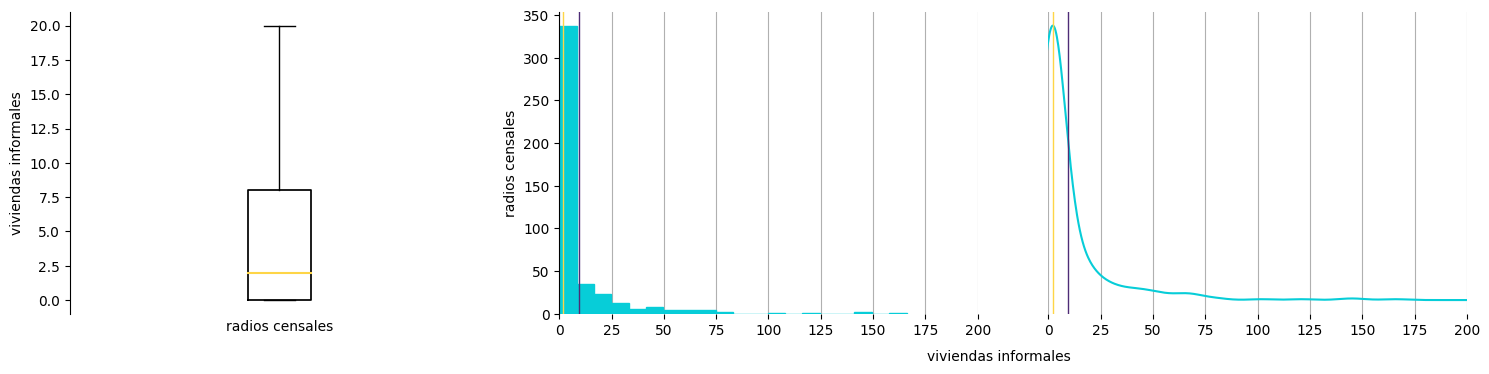

In [35]:
plot_dist_continvar(serie=tipo_vivienda_agg_2010['informal'], figsize=(15,4), fill_hist=True, 
                    xlabel='radios censales', ylabel='viviendas informales', tit=None, bval=20, lim=200)

#### 3.3.3 Viviendas informales por radio censal 2020

In [36]:
tipo_vivienda_agg_2020['informal_2020'].describe()

count    443.000000
mean      19.963883
std       36.944419
min        0.000000
25%        1.000000
50%        6.000000
75%       19.000000
max      319.000000
Name: informal_2020, dtype: float64

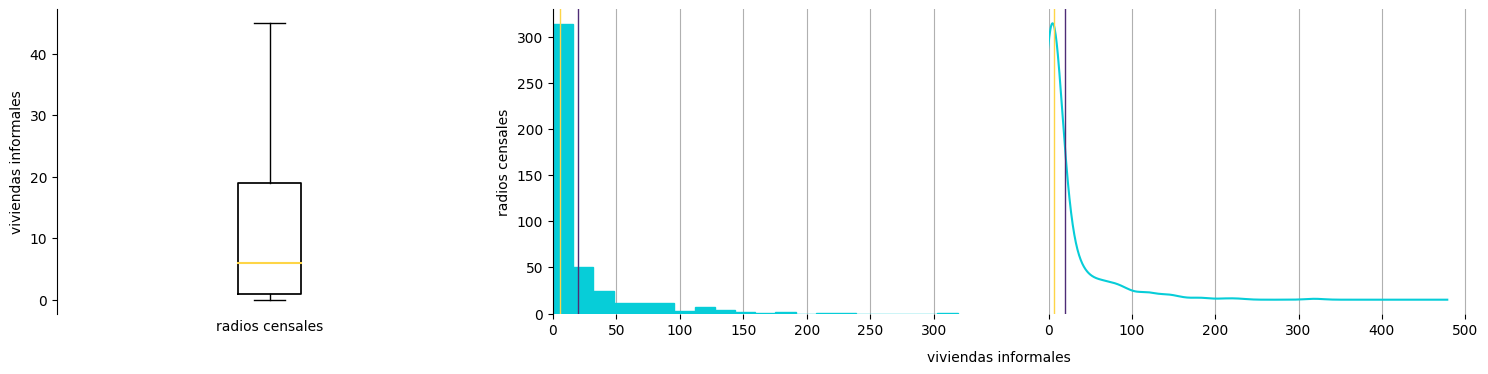

In [37]:
plot_dist_continvar(serie=tipo_vivienda_agg_2020['informal_2020'], figsize=(15,4), fill_hist=True, 
                    xlabel='radios censales', ylabel='viviendas informales', tit=None, bval=20, lim=None)

{'scheme': 'NaturalBreaks', 'k': 4, 'colormap': 'YlOrRd', 'legend': True, 'legend_kwds': {'fmt': '{:.0%}'}}


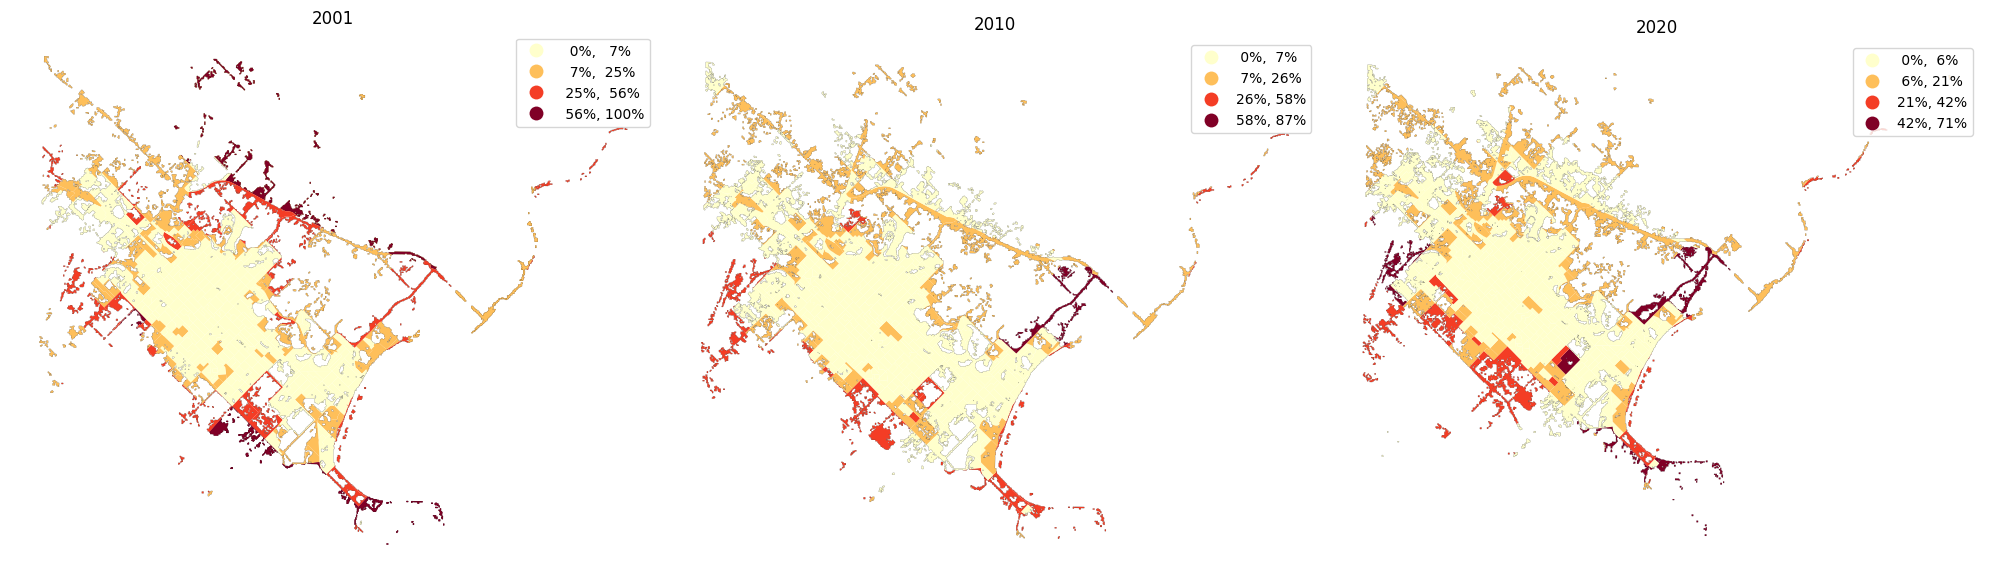

In [38]:
# En procentajes
tipo_vivienda_agg_2020['pct_informal'] = round((tipo_vivienda_agg_2020['informal']/tipo_vivienda_agg_2020['total']),2)
tipo_vivienda_agg_2010['pct_informal'] = round((tipo_vivienda_agg_2010['informal']/tipo_vivienda_agg_2010['total']),2)
tipo_vivienda_agg_2001['pct_informal'] = round((tipo_vivienda_agg_2001['informal']/tipo_vivienda_agg_2001['total']),2)

compare_chropleths(
    tipo_vivienda_agg_2001,
    tipo_vivienda_agg_2010,
    tipo_vivienda_agg_2020,
    column=["pct_informal","pct_informal","pct_informal"],
    titles=[2001, 2010, 2020],
    urban_boundaries = [envolvente_resistencia_00, envolvente_resistencia_10, envolvente_resistencia_20],
    figsize=(20,12),
    legend_kwds = {'fmt':'{:.0%}'},
    scheme = "NaturalBreaks",
    k = 4,
    colormap = 'YlOrRd'
)

{'colormap': 'YlOrRd', 'legend': True, 'legend_kwds': {'shrink': 0.3}}


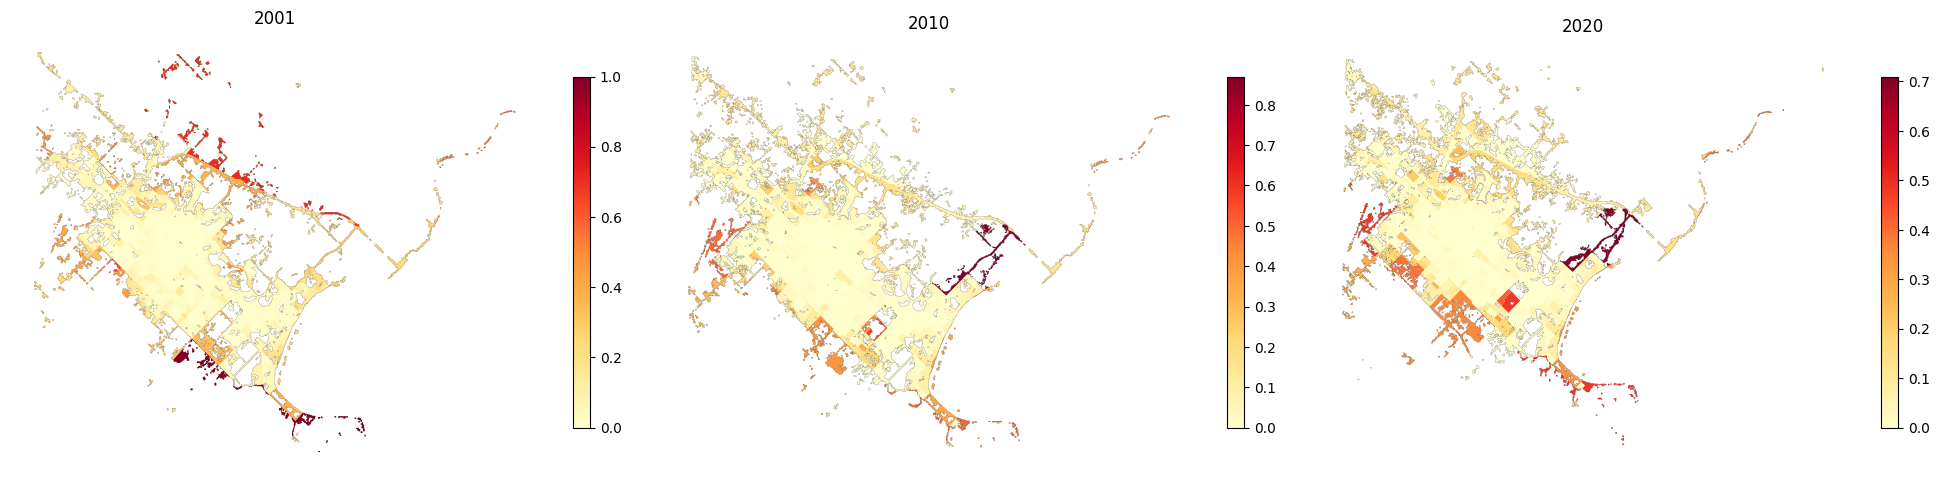

In [39]:
compare_chropleths(
    tipo_vivienda_agg_2001,
    tipo_vivienda_agg_2010,
    tipo_vivienda_agg_2020,
    column=["pct_informal","pct_informal","pct_informal"],
    titles=[2001, 2010, 2020],
    urban_boundaries = [envolvente_resistencia_00, envolvente_resistencia_10, envolvente_resistencia_20],
    figsize=(20,12),
    colormap = 'YlOrRd'
)

### Otras agregaciones

In [40]:
vulnerabilidad_2001 = named_aggregation(
    tipo_vivienda_agg_2001,
    name="vulnerabilidad urbana",
)
vulnerabilidad_2010 = named_aggregation(
    tipo_vivienda_agg_2010,
    name="vulnerabilidad urbana",
)
vulnerabilidad_2020 = named_aggregation(
    tipo_vivienda_agg_2020,
    name="vulnerabilidad urbana",
)

[11:27:32] INFO     Applying named aggregation `vulnerabilidad urbana`                                   ]8;id=553862;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=559996;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py#67\67]8;;\

           INFO     Applying named aggregation `vulnerabilidad urbana`                                   ]8;id=260179;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=700348;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py#67\67]8;;\

           INFO     Applying named aggregation `vulnerabilidad urbana`                                   ]8;id=710148;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=236779;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py#67\67]8;;\

{'scheme': 'NaturalBreaks', 'k': 4, 'colormap': 'YlOrRd', 'legend': True, 'legend_kwds': {'fmt': '{:.0f}'}}


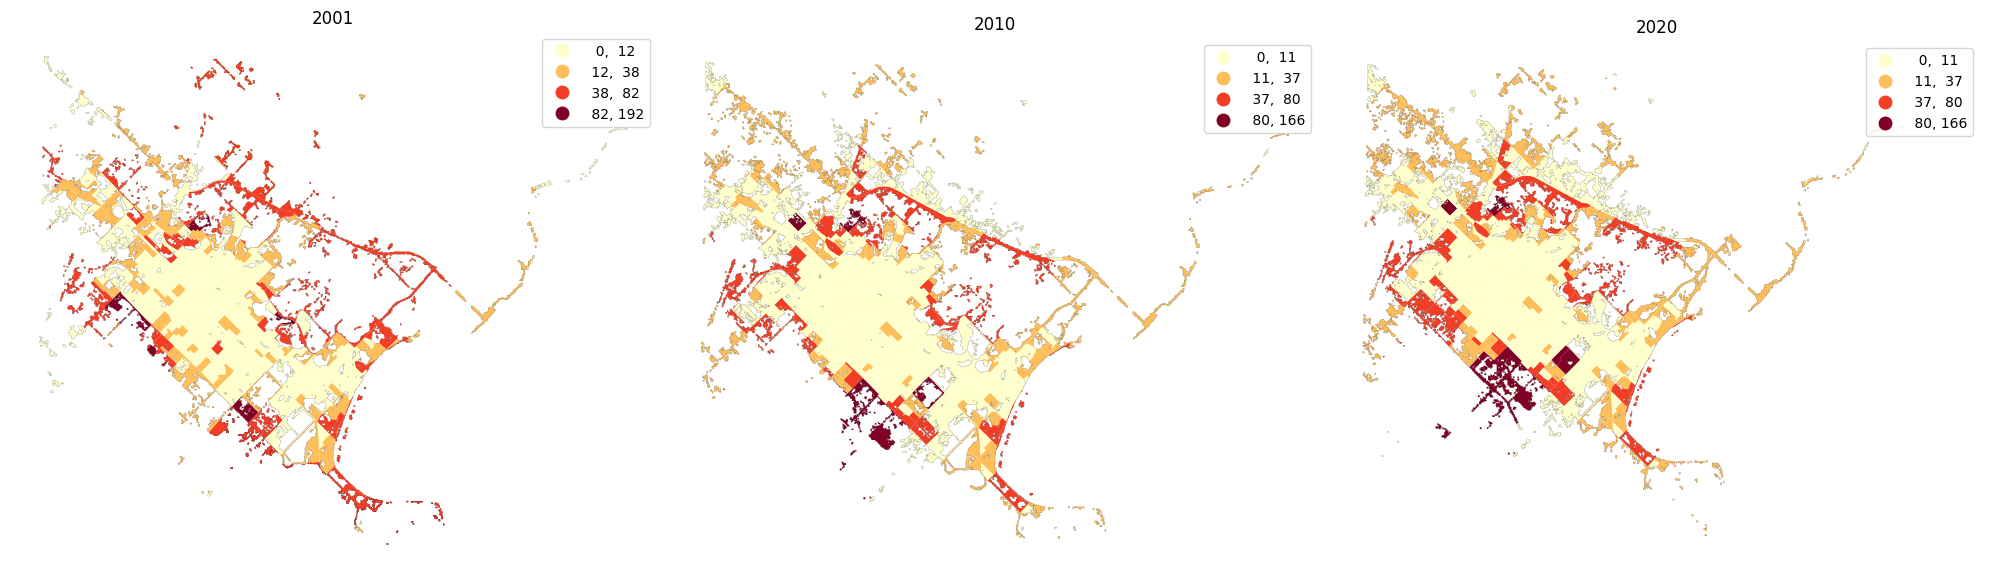

In [41]:
compare_chropleths(
    vulnerabilidad_2001,
    vulnerabilidad_2010,
    vulnerabilidad_2020,
    column=["vulnerable", "vulnerable", "vulnerable"],
    titles=[2001, 2010, 2020],
    urban_boundaries = [envolvente_resistencia_00, envolvente_resistencia_10, envolvente_resistencia_20],
    figsize=(20,12),
    legend_kwds = {'fmt':'{:.0f}'},
    scheme = "NaturalBreaks",
    k = 4,
    colormap = 'YlOrRd'
)

{'colormap': 'YlOrRd', 'legend': True, 'legend_kwds': {'shrink': 0.3}}


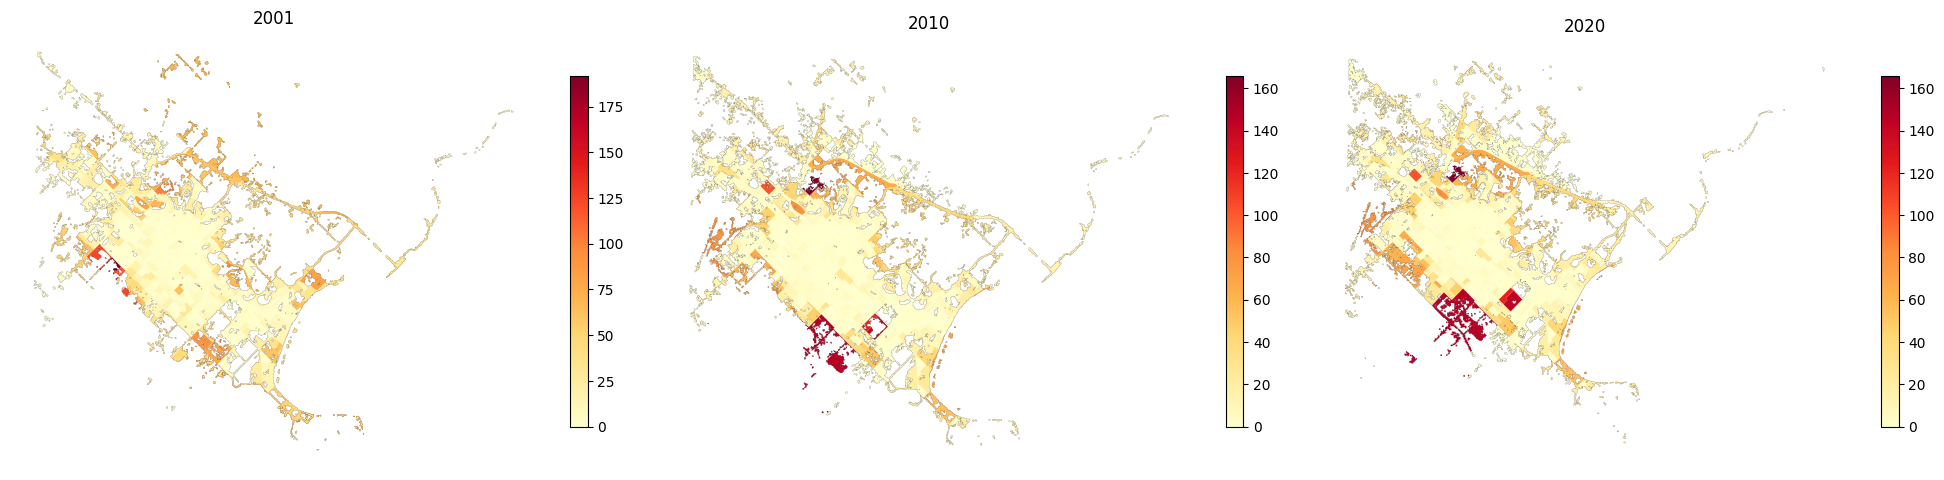

In [42]:
compare_chropleths(
    vulnerabilidad_2001,
    vulnerabilidad_2010,
    vulnerabilidad_2020,
    column=["vulnerable", "vulnerable", "vulnerable"],
    titles=[2001, 2010, 2020],
    urban_boundaries = [envolvente_resistencia_00, envolvente_resistencia_10, envolvente_resistencia_20],
    figsize=(20,12),
    colormap = 'YlOrRd'
)

{'scheme': 'NaturalBreaks', 'k': 4, 'colormap': 'YlOrRd', 'legend': True, 'legend_kwds': {'fmt': '{:.0f}'}}


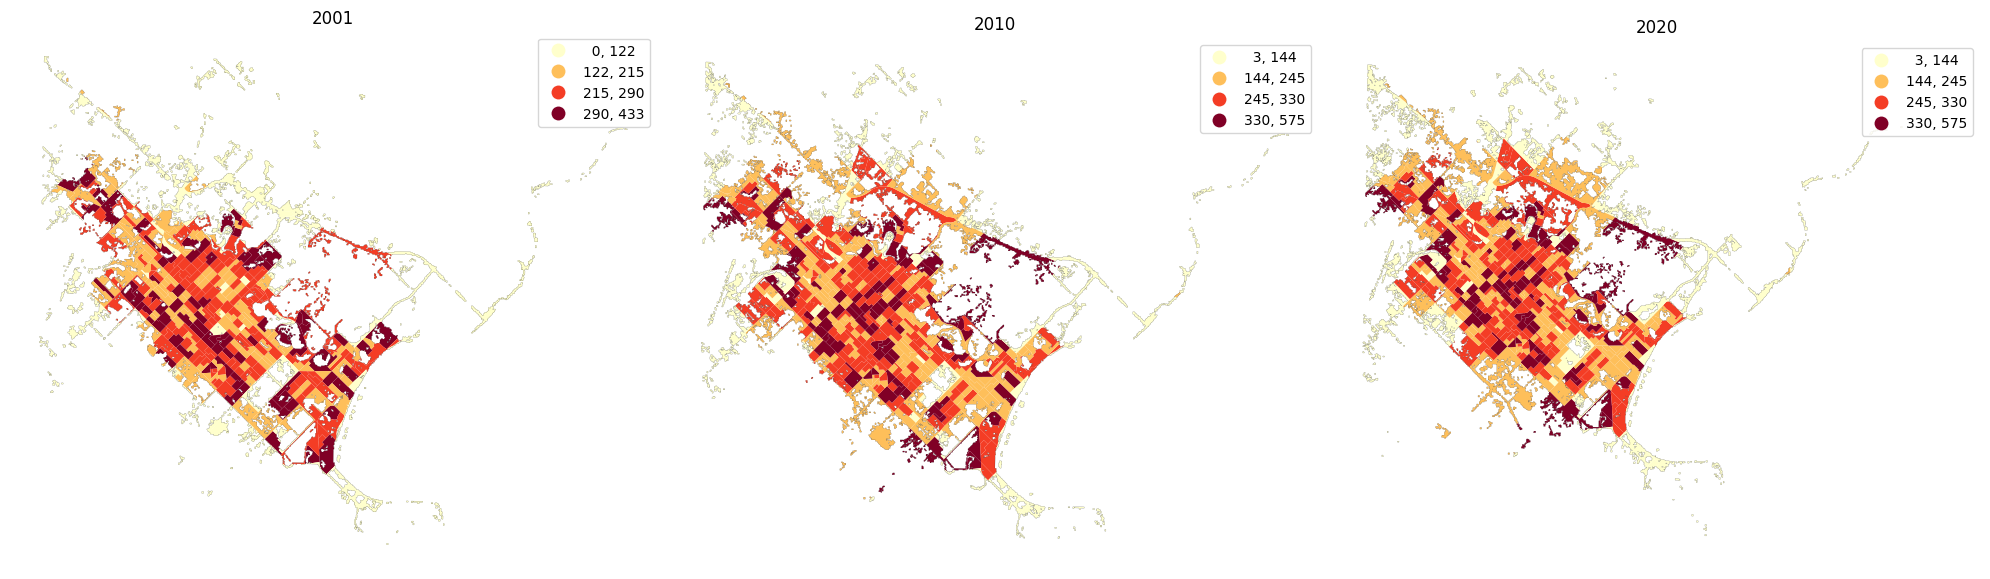

In [43]:
compare_chropleths(
    vulnerabilidad_2001,
    vulnerabilidad_2010,
    vulnerabilidad_2020,
    column=["no vulnerable", "no vulnerable", "no vulnerable"],
    titles=[2001, 2010, 2020],
    urban_boundaries = [envolvente_resistencia_00, envolvente_resistencia_10, envolvente_resistencia_20],
    figsize=(20,12),
    legend_kwds = {'fmt':'{:.0f}'},
    scheme = "NaturalBreaks",
    k = 4,
    colormap = 'YlOrRd'
)

In [44]:
vulnerabilidad_2020['pct_vulnerable'] = round((vulnerabilidad_2020['vulnerable']/vulnerabilidad_2020['total']),2)
vulnerabilidad_2010['pct_vulnerable'] = round((vulnerabilidad_2010['vulnerable']/vulnerabilidad_2010['total']),2)
vulnerabilidad_2001['pct_vulnerable'] = round((vulnerabilidad_2001['vulnerable']/vulnerabilidad_2001['total']),2)

{'scheme': 'NaturalBreaks', 'k': 4, 'colormap': 'YlOrRd', 'legend': True, 'legend_kwds': {'fmt': '{:.0%}'}}


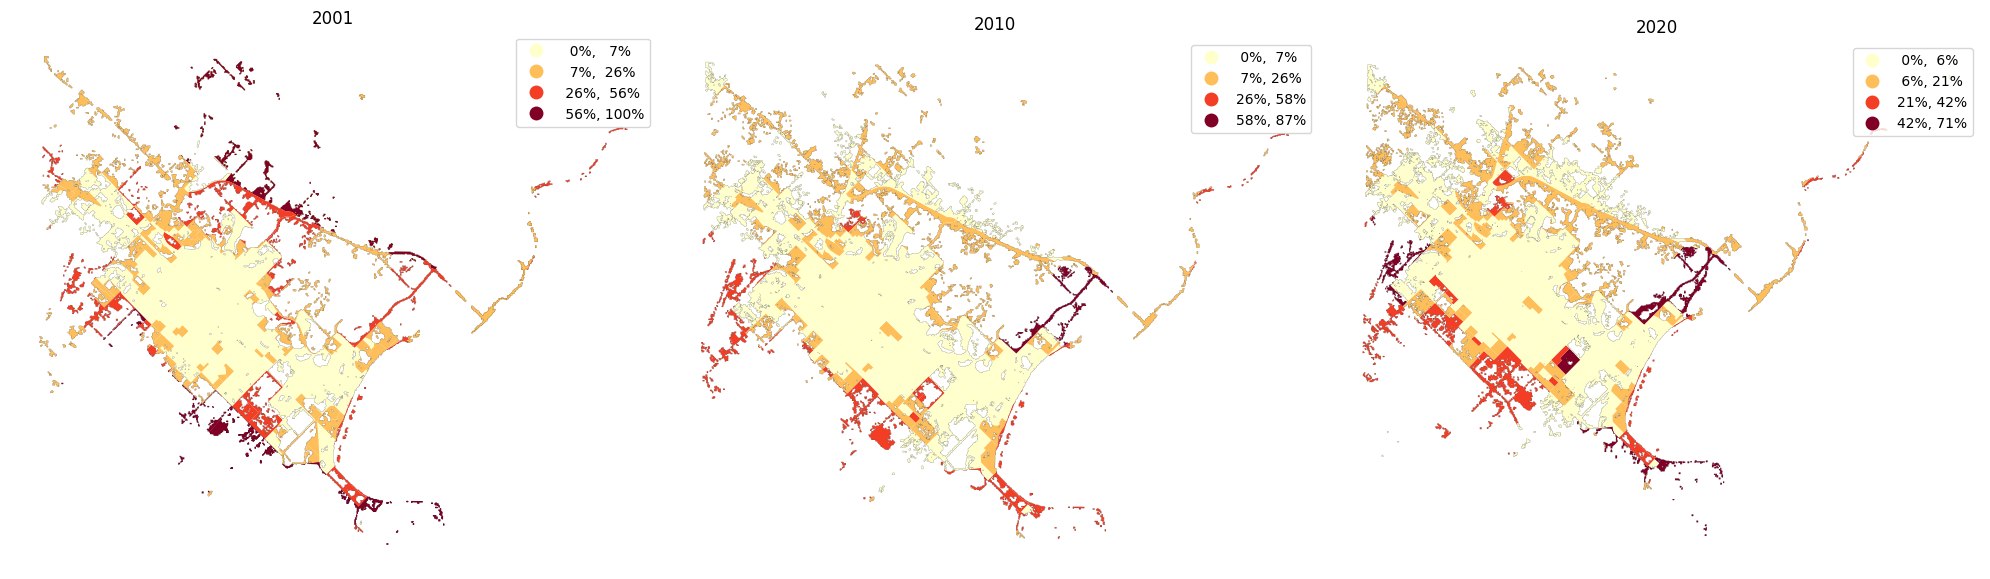

In [45]:
compare_chropleths(
    vulnerabilidad_2001,
    vulnerabilidad_2010,
    vulnerabilidad_2020,
    column=["pct_vulnerable","pct_vulnerable","pct_vulnerable"],
    titles=[2001, 2010, 2020],
    urban_boundaries = [envolvente_resistencia_00, envolvente_resistencia_10, envolvente_resistencia_20],
    figsize=(20,12),
    legend_kwds = {'fmt':'{:.0%}'},
    scheme = "NaturalBreaks",
    k = 4,
    colormap = 'YlOrRd'
)

{'colormap': 'YlOrRd', 'legend': True, 'legend_kwds': {'shrink': 0.3}}


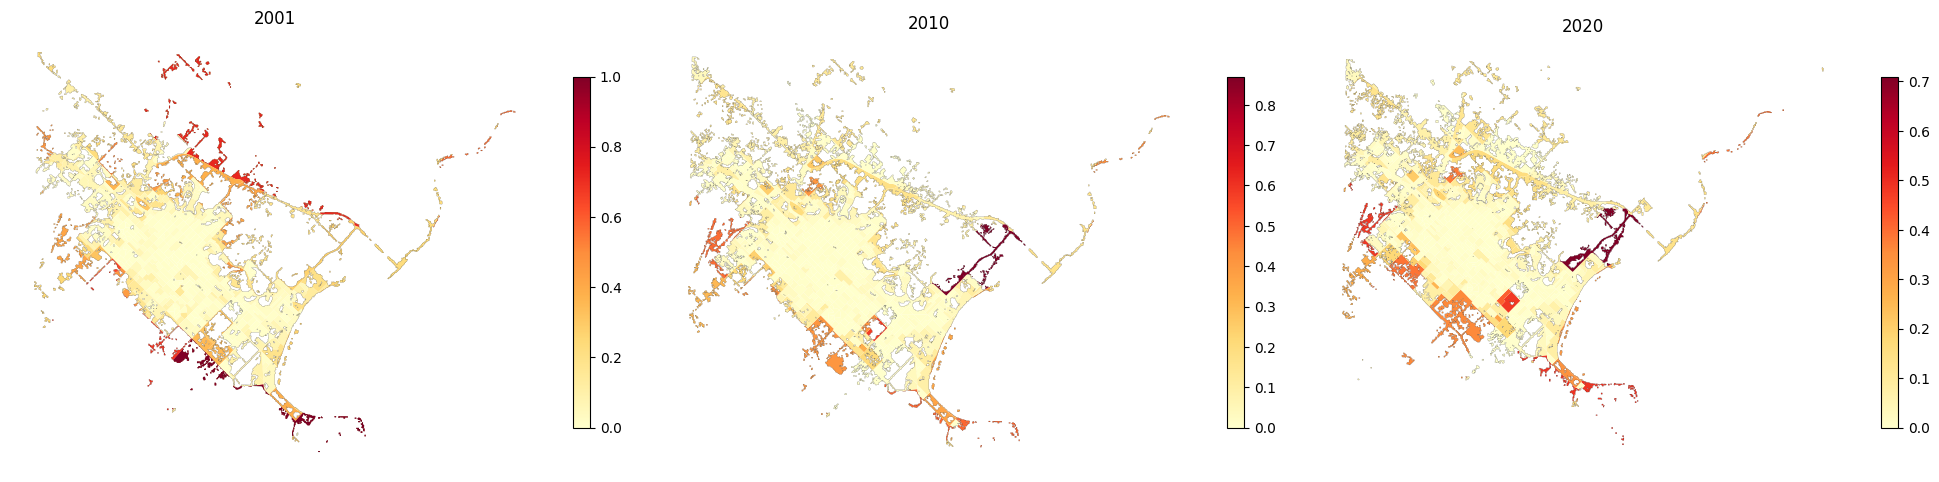

In [46]:
compare_chropleths(
    vulnerabilidad_2001,
    vulnerabilidad_2010,
    vulnerabilidad_2020,
    column=["pct_vulnerable","pct_vulnerable","pct_vulnerable"],
    titles=[2001, 2010, 2020],
    urban_boundaries = [envolvente_resistencia_00, envolvente_resistencia_10, envolvente_resistencia_20],
    figsize=(20,12),
    colormap = 'YlOrRd'
)